# House Prices 데이터 전처리 실습 (연습용)

이 노트북은 Kaggle House Prices 데이터셋(`House Prices - Advanced Regression Techniques.csv`)을 이용해
결측값 처리, 깊은 복사/얕은 복사, 이상치 탐색 등을 단계적으로 연습하기 위한 실습 문제 모음입니다.

## 학습 목표
1. 결측값 탐색과 처리
2. 수치형 vs 범주형 컬럼 별로 다른 방식의 결측값 대체
3. 얕은 복사(shallow copy)와 깊은 복사(deep copy)의 차이
4. 이상치(outlier) 탐지 및 제거 (IQR 방식)
5. 전처리 파이프라인 구성 및 전/후 비교

아래 셀을 먼저 실행해서 데이터를 불러오세요.

In [1]:
!pip install koreanize-matplotlib

In [2]:
import warnings
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from seaborn import load_dataset
from matplotlib import font_manager, rcParams
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기
df = pd.read_csv("../data/05_House Prices - Advanced Regression Techniques.csv")

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 문제 1️⃣: 데이터 구조 파악하기
- 데이터의 행/열 수(shape)를 확인하세요.
- 주요 수치형 변수들의 기본 통계(describe())를 확인하세요.
- info()를 통해 각 컬럼의 결측 여부와 타입을 확인하세요.

In [3]:
# TODO: df.shape, df.describe(), df.info() 등을 이용해 데이터 구조를 살펴보세요.
print(df.shape)
print(df.describe())
print(df.info())

(1460, 81)
                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456

## 문제 2️⃣: 결측값 개수 확인하기
- 각 컬럼별 결측값(null) 개수를 계산하고, 많은 순으로 정렬하여 상위 10개를 출력하세요.
- 어떤 컬럼들이 결측이 심한지 파악하세요.

In [4]:
# TODO: 각 컬럼별 결측값 개수를 세고 상위 10개를 출력하세요.
df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [5]:
df.isnull().sum().sort_values(ascending=False).head(10)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
dtype: int64

## 문제 3️⃣: 결측 비율(%) 확인하기
- 각 컬럼별 결측 비율(결측 개수 / 전체 행 수 * 100)을 구한 뒤,
  비율이 높은 순서대로 정렬하여 상위 10개를 시각화(barh)하세요.
- 그래프 제목: `결측 비율 상위 컬럼`

In [6]:
# TODO: 결측 비율 상위 10개 컬럼을 barh로 시각화하세요.
df2 = (df.isna().sum() / len(df) * 100).sort_values(ascending=False).head(10)
df2

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageQual       5.547945
GarageFinish     5.547945
GarageType       5.547945
dtype: float64

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

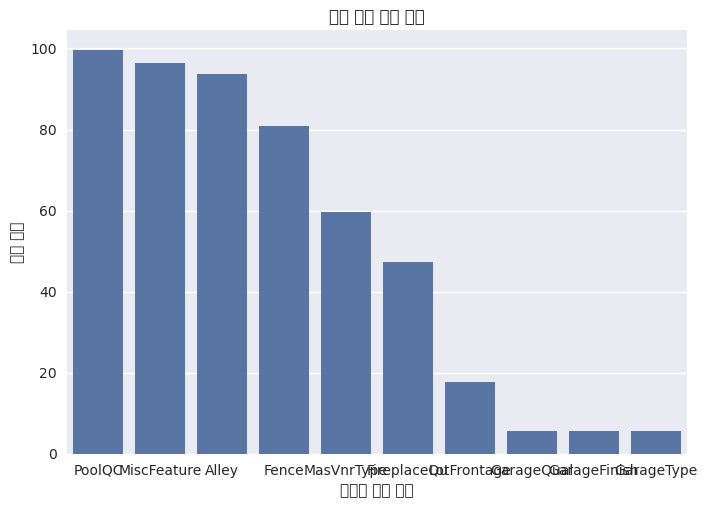

In [7]:
df2 = df2.reset_index()        # index를 컬럼으로 변환
df2.columns = ['결측값 보유 컬럼', '결측 비율']  # 컬럼 이름 지정

plt.figure()
sns.barplot(data=df2, x='결측값 보유 컬럼', y='결측 비율', errorbar=None)
plt.title('결측 비율 상위 컬럼')
plt.show()

In [8]:
df2 = df2.reset_index()
df2

,index,결측값 보유 컬럼,결측 비율
0,0,PoolQC,99.520548
1,1,MiscFeature,96.301370
2,2,Alley,93.767123
3,3,Fence,80.753425
4,4,MasVnrType,59.726027
5,5,FireplaceQu,47.260274
6,6,LotFrontage,17.739726
7,7,GarageQual,5.547945
8,8,GarageFinish,5.547945
9,9,GarageType,5.547945


## 문제 4️⃣: 수치형 결측값 처리 (LotFrontage 예시)
- `LotFrontage`는 땅이 도로와 맞닿은 길이입니다. 이 컬럼은 결측이 존재합니다.
- 1) 원본에서 `LotFrontage`의 평균(mean)과 중앙값(median)을 계산하세요.
- 2) `LotFrontage`의 결측을 **중앙값**으로 채운 새 DataFrame `df_numfilled`를 만드세요.
- 3) 채우기 전/후의 결측 개수를 비교하세요.

In [9]:
# TODO:
# 1) LotFrontage 평균/중앙값 계산
print(df['LotFrontage'].mean())
print(df['LotFrontage'].median())

70.04995836802665
69.0


In [13]:
# 2) 중앙값으로 채운 df_numfilled 생성
df_numfilled = df.copy()

In [20]:
df_numfilled['LotFrontage'] = df_numfilled['LotFrontage'].fillna(df['LotFrontage'].median())
df_numfilled['LotFrontage']

0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1460, dtype: float64

In [21]:
# 3) 채우기 전/후 결측 개수 비교
print(df['LotFrontage'].isnull().sum())
print(df_numfilled['LotFrontage'].isnull().sum())

259
0


## 문제 5️⃣: 범주형 결측값 처리 (GarageType 예시)
- `GarageType`은 차고의 형태(Attached, Detached 등)를 나타냅니다. 결측은 '차고 없음'일 가능성이 큽니다.
- 1) `GarageType`의 현재 고유값(value_counts(dropna=False))을 확인하세요.
- 2) 결측값을 문자열 `'None'`으로 채운 새 DataFrame `df_catfilled`를 만드세요.
- 3) 채우기 전/후 결측 개수를 비교하세요.

In [18]:
# TODO:
# 1) GarageType value_counts(dropna=False)
df['GarageType'].value_counts(dropna=False)

GarageType
Attchd     870
Detchd     387
BuiltIn     88
NaN         81
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64

In [19]:
# 2) 결측을 'None'으로 채운 df_catfilled 생성
df_catfilled = df.copy()

In [25]:
df_catfilled['GarageType'] = df_catfilled['GarageType'].fillna('None')
df_catfilled['GarageType']

0       Attchd
1       Attchd
2       Attchd
3       Detchd
4       Attchd
         ...  
1455    Attchd
1456    Attchd
1457    Attchd
1458    Attchd
1459    Attchd
Name: GarageType, Length: 1460, dtype: object

In [28]:
df_catfilled['GarageType'].value_counts(dropna=False)

GarageType
Attchd     870
Detchd     387
BuiltIn     88
None        81
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64

In [27]:
# 3) 전/후 결측 개수 비교
print(df['GarageType'].isnull().sum())
print(df_catfilled['GarageType'].isnull().sum())

81
0


## 문제 6️⃣: 전체 결측 처리 버전 만들기
- 다음 규칙으로 새로운 DataFrame `df_filled`를 만드세요.
  - 수치형 컬럼은 중앙값(median)으로 채운다.
  - 범주형 컬럼(object 타입)은 `'Unknown'`으로 채운다.
- 그런 다음 df_filled에 남아있는 결측값 개수를 모두 합산하여 출력하세요.

In [31]:
# TODO:
# df_filled를 만들고 수치형=중앙값, 범주형='Unknown'으로 채운 뒤
# 남은 결측 총합을 출력하세요.
df_filled= df.copy()

df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [33]:
df_filled.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [40]:
num_cols = ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
                 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
                 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

In [47]:
cat_cols = ['MSZoning','Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
                 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 
                 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
                 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
                 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

In [51]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include='object').columns

In [52]:
df_filled_num = df[num_cols].copy()
df_filled_num

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


In [53]:
df_filled_num = df_filled_num.fillna(df_filled_num.median())
df_filled_num.isnull().sum()

Id               0
MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SalePrice        0
dtype: int64

In [54]:
df_filled_cat = df[cat_cols].copy()
df_filled_cat

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [55]:
df_filled_cat = df_filled_cat.fillna('Unknown')
df_filled_cat.isnull().sum()

MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
MiscFeature      0
SaleType         0
SaleCondition    0
dtype: int64

In [58]:
df_filled = pd.concat([df_filled_num, df_filled_cat], axis=1)
df_filled.isnull().sum().sum()

np.int64(0)

## 문제 7️⃣: 얕은 복사 vs 깊은 복사
- 얕은 복사(shallow copy)와 깊은 복사(deep copy)의 차이를 관찰해봅니다.
- 1) `df_shallow = df` 로 얕은 복사를 만드세요.
- 2) `df_deep = df.copy()` 로 깊은 복사를 만드세요.
- 3) 얕은 복사 쪽의 특정 컬럼(예: `LotArea`) 값을 변경했을 때 원본 df도 함께 바뀌는지 확인하세요.
- 4) 깊은 복사쪽은 독립적인지 확인하세요.

In [59]:
# TODO:
# df_shallow = df
# df_deep = df.copy()
# df_shallow의 LotArea 첫 값을 수정하고 df/deep 비교하세요.
# (실습 후 원복도 시도해보세요.)
df_shallow = df
df_deep = df.copy()

In [60]:
df_shallow['LotArea'] = 423

In [62]:
df['LotArea']

0       423
1       423
2       423
3       423
4       423
       ... 
1455    423
1456    423
1457    423
1458    423
1459    423
Name: LotArea, Length: 1460, dtype: int64

In [63]:
df_deep['LotArea'] = 417

In [65]:
df['LotArea']

0       423
1       423
2       423
3       423
4       423
       ... 
1455    423
1456    423
1457    423
1458    423
1459    423
Name: LotArea, Length: 1460, dtype: int64

얕은 복사는 값을 변경하면 원본에도 반영, 깊은 복사는 원본 반영 X